<a href="https://colab.research.google.com/github/jocontreras/AngularJS/blob/master/Yet_another_copy_of_3d_printing_preprocessing_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 3D Printing Dataset Cleaning & Preprocessing (using Predictive imputation KNN)

**Pre-processing using Mean Imputation**  
- Missing data handling (numeric medians, categorical modes, optional target imputation)  
- Outlier capping (IQR)  
- One-hot encoding (categoricals)  
- Standard scaling (numerics)  

> Targets expected (if present): `roughness`, `tension_strength`, `elongation`


In [ ]:

# Step 0: (Optional) Ensure libs are present in Colab
#!pip -q install scikit-learn joblib pandas numpy



## 1) Upload your dataset
Upload a CSV that includes typical 3D printing columns like:
`layer_height, wall_thickness, infill_density, infill_pattern, nozzle_temperature, bed_temperature, print_speed, material, fan_speed`  
and (optionally) targets: `roughness, tension_strength, elongation`.


In [ ]:

from google.colab import files
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

uploaded = files.upload()
filename = list(uploaded.keys())[0]  # first uploaded file
df = pd.read_csv(filename)
print("Dataset loaded:", filename, "with shape", df.shape)
display(df.head(5))


Saving For Cleaning Dataset  Sept 1 - WIP Dataset - Sheet1.csv to For Cleaning Dataset  Sept 1 - WIP Dataset - Sheet1.csv
Dataset loaded: For Cleaning Dataset  Sept 1 - WIP Dataset - Sheet1.csv with shape (513, 16)


,ID,material,layer_height (mm),wall_thickness (mm),infill_density (%),infill_pattern,nozzle_temperature (°C),bed_temperature (°C),print_speed (mm/s),fan_speed (%),surface_roughness (µm),tension_strength (MPa),elongation (%),souce,title,url
0,1,ABS,0.02,8,90.0,grid,220.0,60.0,40.0,0,25,18.0,1.20,Kaggle,Probability and Statistics: 3D Printer Dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
1,2,ABS,0.02,7,90.0,honeycomb,225.0,65.0,40.0,25,32,16.0,1.40,Kaggle,Probability and Statistics: 3D Printer Dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
2,3,ABS,0.02,1,80.0,grid,230.0,70.0,40.0,50,40,8.0,0.80,Kaggle,Probability and Statistics: 3D Printer Dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
3,4,ABS,0.02,4,70.0,honeycomb,240.0,75.0,40.0,75,68,10.0,0.50,Kaggle,Probability and Statistics: 3D Printer Dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
4,5,ABS,0.02,6,90.0,grid,250.0,80.0,40.0,100,92,5.0,0.70,Kaggle,Probability and Statistics: 3D Printer Dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...



## 2) Inspect & Missingness (BEFORE)
We generate quick summaries including data types and missingness counts (BEFORE any cleaning).


In [ ]:

import numpy as np

print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

def summarize_missingness(frame: pd.DataFrame) -> pd.DataFrame:
    miss = frame.isna().sum().to_frame("missing")
    miss["pct"] = 100 * miss["missing"] / len(frame) if len(frame) else 0
    return miss.sort_values("missing", ascending=False)

miss_before = summarize_missingness(df)
display(miss_before.head(30))


Shape: (513, 16)

Data Types:
 ID                           int64
material                    object
layer_height (mm)          float64
wall_thickness (mm)         object
infill_density (%)         float64
infill_pattern              object
nozzle_temperature (°C)    float64
bed_temperature (°C)       float64
print_speed (mm/s)         float64
fan_speed (%)               object
surface_roughness (µm)      object
tension_strength (MPa)     float64
elongation (%)              object
souce                       object
title                       object
url                         object
dtype: object


,missing,pct
fan_speed (%),314,61.208577
wall_thickness (mm),294,57.309942
surface_roughness (µm),264,51.461988
infill_pattern,212,41.325536
elongation (%),151,29.434698
bed_temperature (°C),99,19.298246
print_speed (mm/s),82,15.984405
tension_strength (MPa),49,9.551657
infill_density (%),22,4.288499
layer_height (mm),16,3.118908



###Visualize missingness (BEFORE)


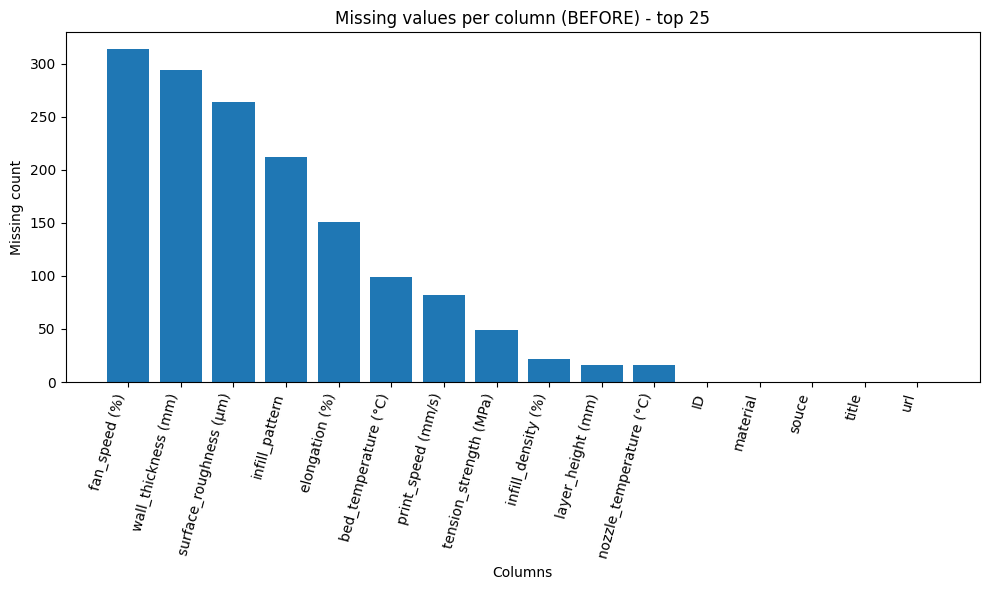

In [ ]:

import matplotlib.pyplot as plt

top_n = 25
mb = miss_before.head(top_n)
plt.figure(figsize=(10, 6))
plt.bar(mb.index.astype(str), mb["missing"])
plt.xticks(rotation=75, ha="right")
plt.title("Missing values per column (BEFORE) - top %d" % top_n)
plt.xlabel("Columns")
plt.ylabel("Missing count")
plt.tight_layout()
plt.show()


In [ ]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.lower()

display(df.head())

,ID,material,layer_height (mm),wall_thickness (mm),infill_density (%),infill_pattern,nozzle_temperature (°C),bed_temperature (°C),print_speed (mm/s),fan_speed (%),surface_roughness (µm),tension_strength (MPa),elongation (%),souce,title,url
0,1,abs,0.02,8,90.0,grid,220.0,60.0,40.0,0,25,18.0,1.20,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
1,2,abs,0.02,7,90.0,honeycomb,225.0,65.0,40.0,25,32,16.0,1.40,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
2,3,abs,0.02,1,80.0,grid,230.0,70.0,40.0,50,40,8.0,0.80,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
3,4,abs,0.02,4,70.0,honeycomb,240.0,75.0,40.0,75,68,10.0,0.50,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
4,5,abs,0.02,6,90.0,grid,250.0,80.0,40.0,100,92,5.0,0.70,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...


In [ ]:
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd

# Handling Missing Data

# Define a threshold for dropping rows (e.g., drop rows with more than 70% missing values)
missing_threshold_row = 0.7

# Calculate the percentage of missing values for each row
row_missing_percentage = df.isnull().sum(axis=1) / len(df.columns)

# Drop rows that exceed the missingness threshold
rows_to_drop = row_missing_percentage[row_missing_percentage > missing_threshold_row].index
df_cleaned = df.drop(rows_to_drop, axis=0).reset_index(drop=True)

# Define a threshold for dropping columns (e.g., drop columns with more than 50% missing values)
missing_threshold_col = 0.5

# Calculate the percentage of missing values for each column
col_missing_percentage = df_cleaned.isnull().sum() / len(df_cleaned)

# Identify columns to drop
cols_to_drop = col_missing_percentage[col_missing_percentage > missing_threshold_col].index
df_cleaned = df_cleaned.drop(cols_to_drop, axis=1)

# Standardizing Data Formats (Attempt to convert to numeric before imputation)
for col in df_cleaned.columns:
    # Exclude known object columns that are not intended to be numeric
    if col not in ['material', 'infill_pattern', 'souce', 'title', 'url']:
        # Attempt to convert to numeric, coercing errors will turn invalid parsing into NaN
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')


# Imputation with KNN for numerical and mode for categorical

# Impute numerical columns using KNNImputer
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns
if not df_cleaned[numerical_cols].isnull().empty:
    imputer = KNNImputer(n_neighbors=5) # You can adjust n_neighbors
    df_cleaned[numerical_cols] = imputer.fit_transform(df_cleaned[numerical_cols])


# Impute categorical columns with the mode
categorical_cols = df_cleaned.select_dtypes(include='object').columns
for col in categorical_cols:
    if df_cleaned[col].isnull().any():
        mode_val = df_cleaned[col].mode()[0] # mode() can return multiple values, take the first
        df_cleaned[col].fillna(mode_val, inplace=True)


print("Missing values after handling:")
display(df_cleaned.isnull().sum().to_frame("missing").head(30))

Missing values after handling:


/tmp/ipython-input-3950187566.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(mode_val, inplace=True)


,missing
ID,0
material,0
layer_height (mm),0
infill_density (%),0
infill_pattern,0
nozzle_temperature (°C),0
bed_temperature (°C),0
print_speed (mm/s),0
tension_strength (MPa),0
elongation (%),0


In [ ]:
print("Shape of cleaned dataframe:", df_cleaned.shape)
display(df_cleaned.head())



Shape of cleaned dataframe: (513, 13)


,ID,material,layer_height (mm),infill_density (%),infill_pattern,nozzle_temperature (°C),bed_temperature (°C),print_speed (mm/s),tension_strength (MPa),elongation (%),souce,title,url
0,1.0,abs,0.02,90.0,grid,220.0,60.0,40.0,18.0,1.2,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
1,2.0,abs,0.02,90.0,honeycomb,225.0,65.0,40.0,16.0,1.4,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
2,3.0,abs,0.02,80.0,grid,230.0,70.0,40.0,8.0,0.8,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
3,4.0,abs,0.02,70.0,honeycomb,240.0,75.0,40.0,10.0,0.5,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
4,5.0,abs,0.02,90.0,grid,250.0,80.0,40.0,5.0,0.7,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...


In [ ]:
#For Handling Outliers
class IQRCapper(BaseEstimator, TransformerMixin):
    """Cap outliers per numeric column using [Q1-1.5*IQR, Q3+1.5*IQR]."""
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_ = (q1 - 1.5 * iqr).to_dict()
        self.upper_ = (q3 + 1.5 * iqr).to_dict()
        self.columns_ = list(X.columns)
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            low = self.lower_.get(col, None)
            up = self.upper_.get(col, None)
            if low is not None and up is not None:
                X[col] = np.clip(X[col], low, up)
        return X.values

    def get_feature_names_out(self, input_features=None):
        """Return the column names."""
        return self.columns_


class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Adds domain features: energy, thermal_ratio, wall_infill."""
    def __init__(self,
                 nozzle_col='nozzle_temperature (°C)',
                 bed_col='bed_temperature (°C)',
                 speed_col='print_speed (mm/s)',
                 wall_col='wall_thickness (mm)',
                 infill_col='infill_density (%)'):
        self.nozzle_col = nozzle_col
        self.bed_col = bed_col
        self.speed_col = speed_col
        self.wall_col = wall_col
        self.infill_col = infill_col
        self.added_columns_ = [] # Initialize as empty list
    def fit(self, X, y=None):
        X = X.copy()
        self.added_columns_ = []
        if self.nozzle_col in X.columns and self.speed_col in X.columns and X[[self.nozzle_col, self.speed_col]].notna().any().all():
             self.added_columns_.append("energy")
        if self.nozzle_col in X.columns and self.bed_col in X.columns and X[[self.nozzle_col, self.bed_col]].notna().any().all():
             self.added_columns_.append("thermal_ratio")
        if self.wall_col in X.columns and self.infill_col in X.columns and X[[self.wall_col, self.infill_col]].notna().any().all():
             self.added_columns_.append("wall_infill")
        return self

    def transform(self, X):
        X = X.copy()
        # Add 'energy' if relevant columns exist and have non-missing values and was added in fit
        if "energy" in self.added_columns_:
            X["energy"] = X[self.nozzle_col].astype(float) * X[self.speed_col].astype(float)

        # Add 'thermal_ratio' if relevant columns exist and have non-missing values and was added in fit
        if "thermal_ratio" in self.added_columns_:
            X["thermal_ratio"] = np.where(X[self.nozzle_col].astype(float)==0, np.nan,
                                      X[self.bed_col].astype(float) / X[self.nozzle_col].astype(float))

        # Add 'wall_infill' if relevant columns exist and have non-missing values and was added in fit
        if "wall_infill" in self.added_columns_:
             X["wall_infill"] = X[self.wall_col].astype(float) * X[self.infill_col].astype(float)

        return X

    def get_feature_names_out(self, input_features=None):
      """Return the column names."""
      return input_features + self.added_columns_

In [ ]:
# Handling Outliers using IQR Capping

# Instantiate the IQRCapper
iqr_capper = IQRCapper()

# Select numerical columns for outlier capping
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns

# Apply IQR Capping to numerical columns
df_cleaned[numerical_cols] = iqr_capper.fit_transform(df_cleaned[numerical_cols])

print("Outliers handled using IQR capping.")
display(df_cleaned.head())

Outliers handled using IQR capping.


,ID,material,layer_height (mm),infill_density (%),infill_pattern,nozzle_temperature (°C),bed_temperature (°C),print_speed (mm/s),tension_strength (MPa),elongation (%),souce,title,url
0,1.0,abs,0.02,90.0,grid,220.0,60.0,40.0,18.0,1.2,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
1,2.0,abs,0.02,90.0,honeycomb,225.0,65.0,40.0,16.0,1.4,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
2,3.0,abs,0.02,80.0,grid,230.0,70.0,40.0,8.0,0.8,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
3,4.0,abs,0.02,70.0,honeycomb,240.0,75.0,40.0,10.0,0.5,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
4,5.0,abs,0.02,90.0,grid,250.0,80.0,40.0,5.0,0.7,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...


Boxplots BEFORE IQR Capping:


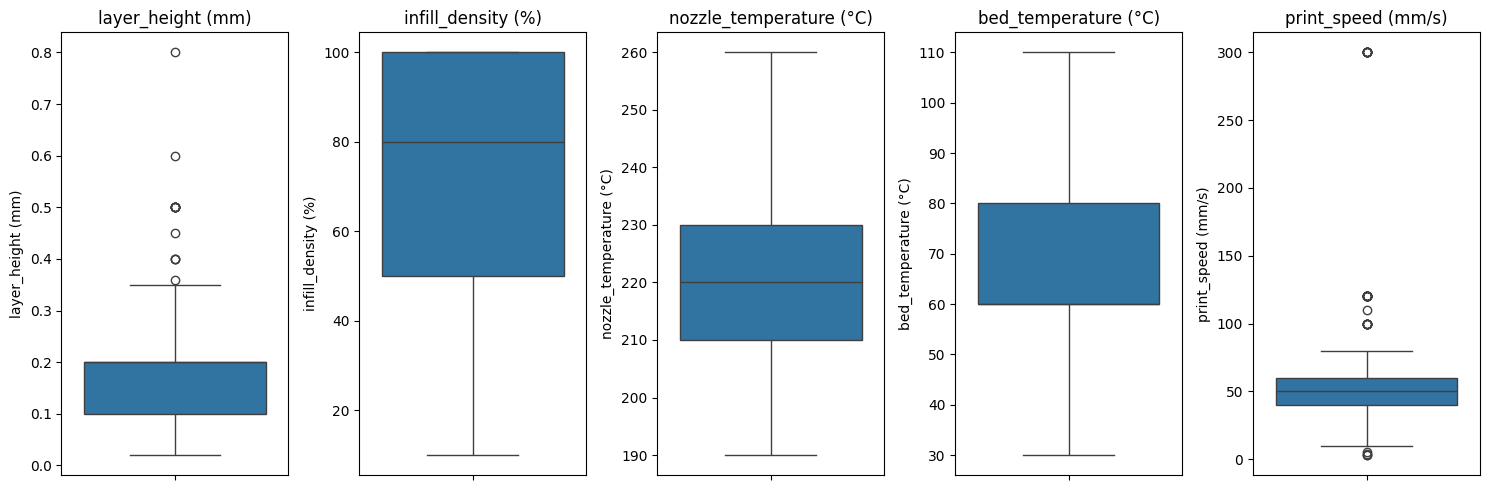


Boxplots AFTER IQR Capping:


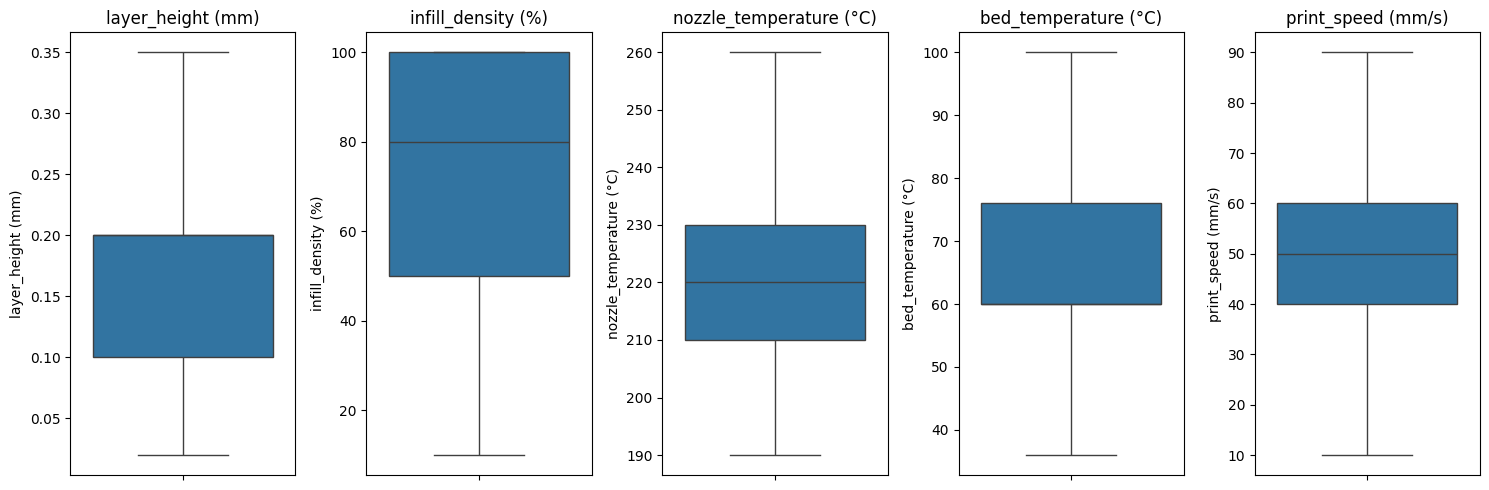

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few numerical columns to visualize
cols_to_visualize = ['layer_height (mm)', 'infill_density (%)', 'nozzle_temperature (°C)', 'bed_temperature (°C)', 'print_speed (mm/s)']

print("Boxplots BEFORE IQR Capping:")
plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_to_visualize):
    plt.subplot(1, len(cols_to_visualize), i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

print("\nBoxplots AFTER IQR Capping:")
plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_to_visualize):
    plt.subplot(1, len(cols_to_visualize), i + 1)
    sns.boxplot(y=df_cleaned[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
# Standardizing Data Formats

# Attempt to convert potentially numeric columns to numeric type
for col in df_cleaned.columns:
    # Exclude known object columns that are not intended to be numeric
    if col not in ['material', 'infill_pattern', 'souce', 'title', 'url']:
        # Attempt to convert to numeric, coercing errors will turn invalid parsing into NaN
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Although missing values were imputed before, check again in case coercion introduced new NaNs
# Impute numerical columns with the median if any new NaNs were created by coercion
for col in df_cleaned.select_dtypes(include=np.number).columns:
    if df_cleaned[col].isnull().any():
        median_val = df_cleaned[col].median()
        df_cleaned[col].fillna(median_val, inplace=True)

print("Data formats standardized and potential new NaNs imputed.")
display(df_cleaned.head())

Data formats standardized and potential new NaNs imputed.


,ID,material,layer_height (mm),infill_density (%),infill_pattern,nozzle_temperature (°C),bed_temperature (°C),print_speed (mm/s),tension_strength (MPa),elongation (%),souce,title,url
0,1.0,abs,0.02,90.0,grid,220.0,60.0,40.0,18.0,1.2,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
1,2.0,abs,0.02,90.0,honeycomb,225.0,65.0,40.0,16.0,1.4,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
2,3.0,abs,0.02,80.0,grid,230.0,70.0,40.0,8.0,0.8,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
3,4.0,abs,0.02,70.0,honeycomb,240.0,75.0,40.0,10.0,0.5,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...
4,5.0,abs,0.02,90.0,grid,250.0,80.0,40.0,5.0,0.7,kaggle,probability and statistics: 3d printer dataset...,https://www.kaggle.com/datasets/afumetto/3dpri...


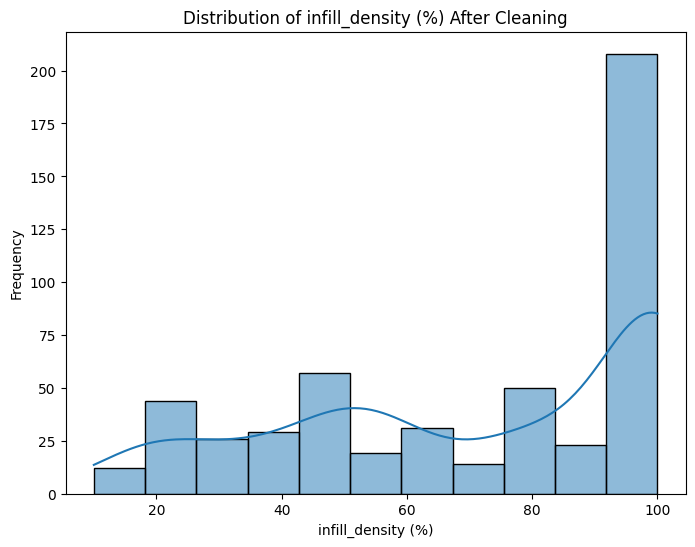

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of a cleaned numerical column as an example
column_to_visualize = 'infill_density (%)'

plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned[column_to_visualize], kde=True)
plt.title(f'Distribution of {column_to_visualize} After Cleaning')
plt.xlabel(column_to_visualize)
plt.ylabel('Frequency')
plt.show()

In [ ]:
print("Columns in the cleaned dataframe:")
print(df_cleaned.columns)
print("\nData types of the cleaned dataframe:")
print(df_cleaned.dtypes)

Columns in the cleaned dataframe:
Index(['ID', 'material', 'layer_height (mm)', 'infill_density (%)',
       'infill_pattern', 'nozzle_temperature (°C)', 'bed_temperature (°C)',
       'print_speed (mm/s)', 'tension_strength (MPa)', 'elongation (%)',
       'souce', 'title', 'url'],
      dtype='object')

Data types of the cleaned dataframe:
ID                         float64
material                    object
layer_height (mm)          float64
infill_density (%)         float64
infill_pattern              object
nozzle_temperature (°C)    float64
bed_temperature (°C)       float64
print_speed (mm/s)         float64
tension_strength (MPa)     float64
elongation (%)             float64
souce                       object
title                       object
url                         object
dtype: object


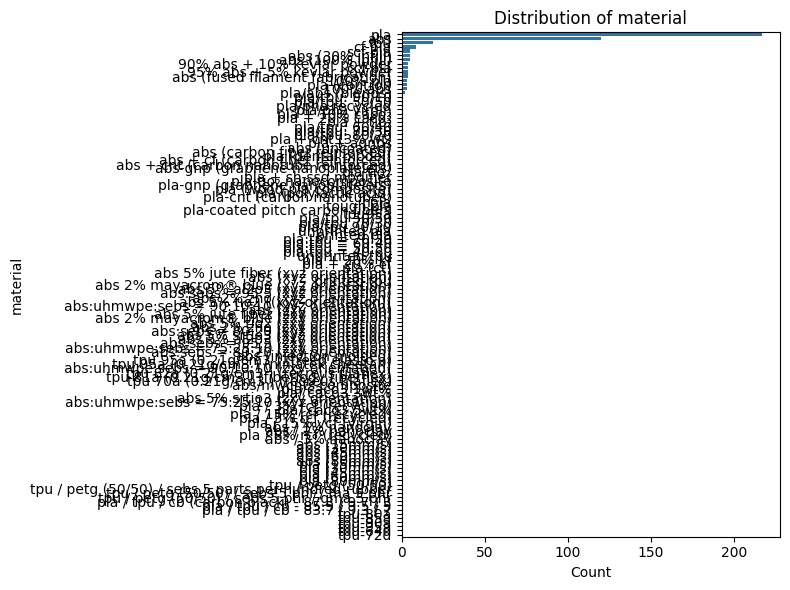

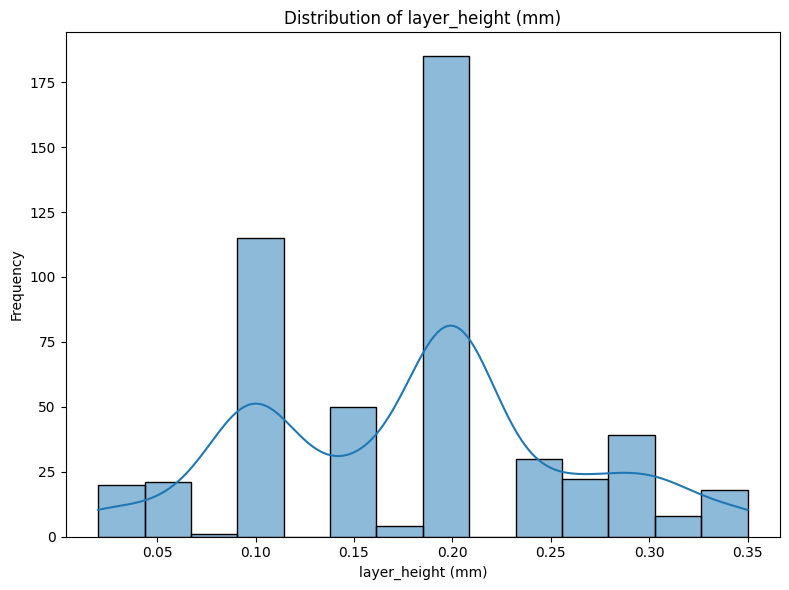

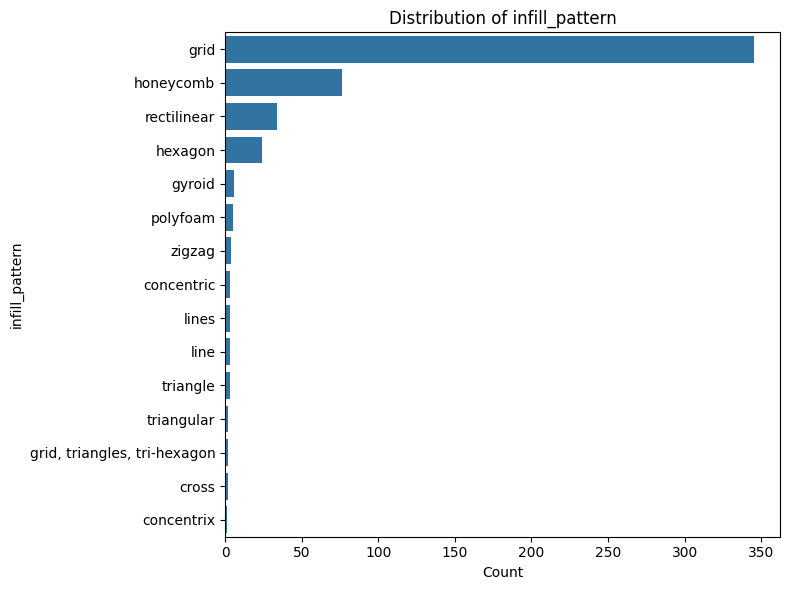

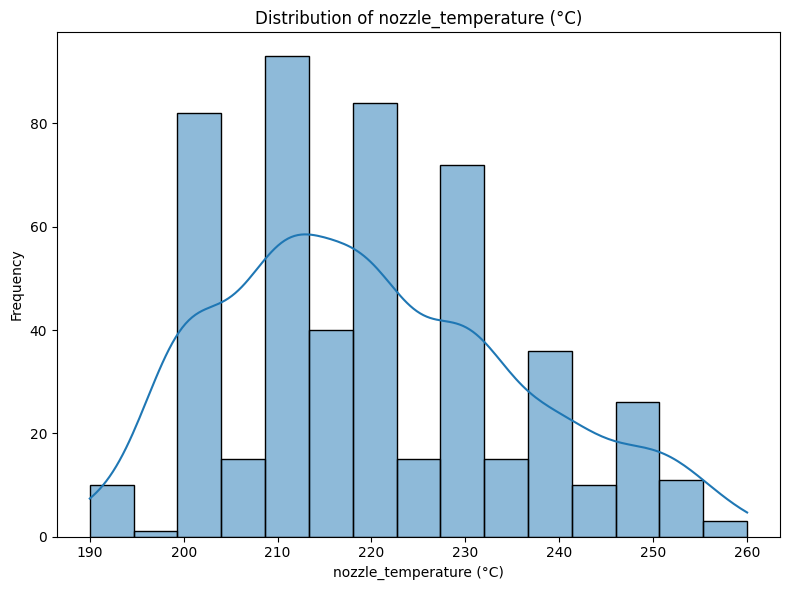

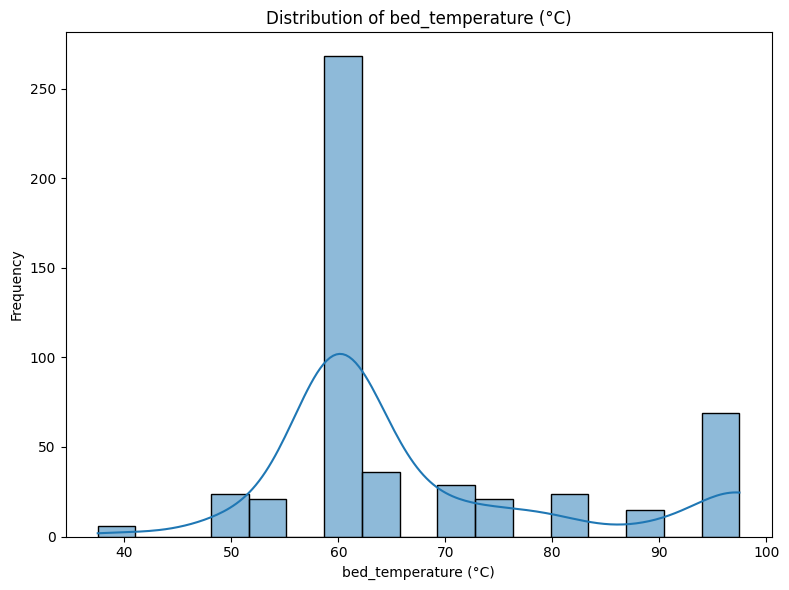

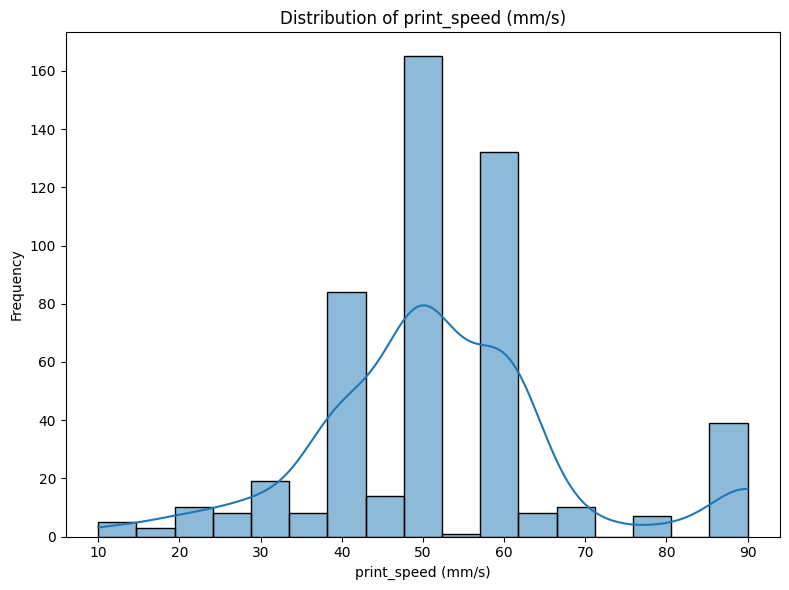

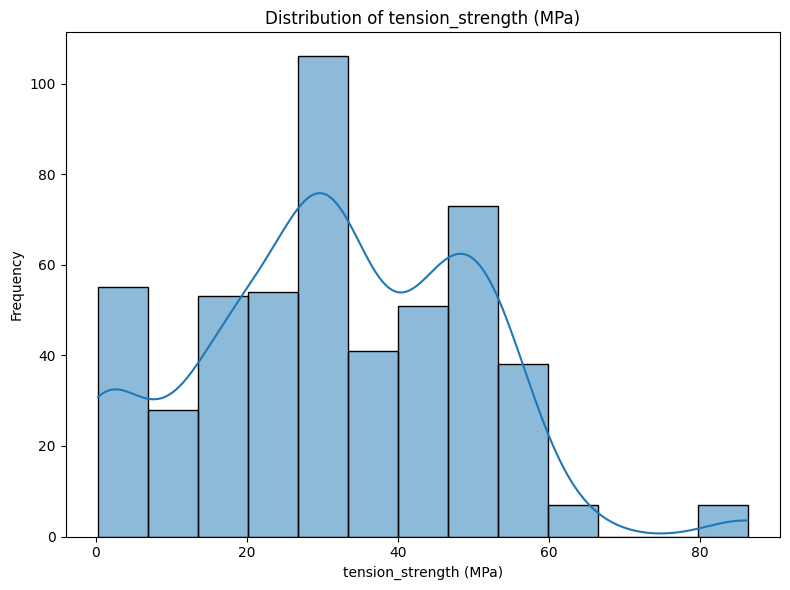

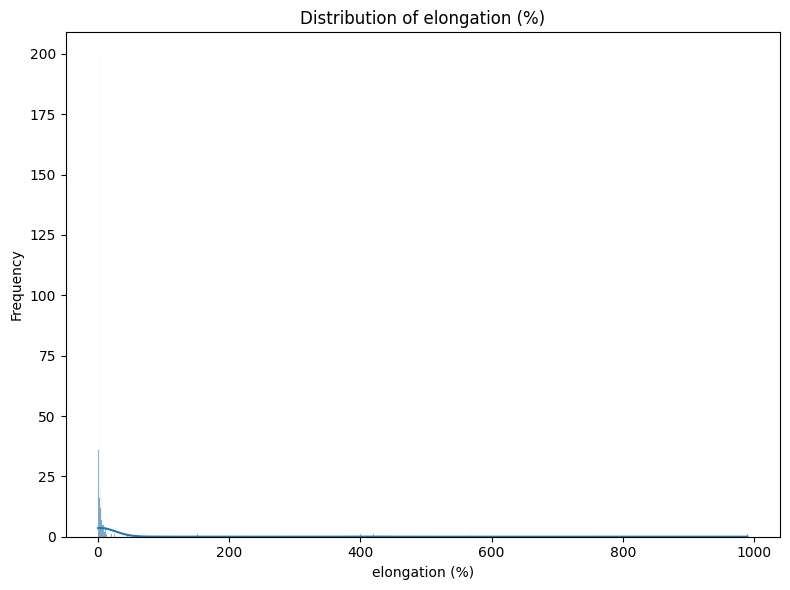

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_visualize = ['material', 'layer_height (mm)', 'infill_pattern', 'nozzle_temperature (°C)', 'bed_temperature (°C)', 'print_speed (mm/s)', 'tension_strength (MPa)', 'elongation (%)']

for col in cols_to_visualize:
    plt.figure(figsize=(8, 6))
    if df_cleaned[col].dtype == 'object':
        sns.countplot(y=df_cleaned[col], order=df_cleaned[col].value_counts().index)
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
    else:
        sns.histplot(df_cleaned[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

The missingness report in the previous step (`iRz8TA2Xljo_`) shows that there are no missing values remaining after the cleaning process. This visualization shows the distribution of a representative column after cleaning and imputation.

In [ ]:
from google.colab import files

# Save the pre-processed dataframe to a CSV file
output_filename = 'preprocessed_dataset.csv'
df_cleaned.to_csv(output_filename, index=False)

# Provide a link to download the file
print(f"Dataset saved as {output_filename}")
files.download(output_filename)

Dataset saved as preprocessed_dataset.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>